In [1]:
import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import torch.nn.functional as F
import pandas as pd

# Configuration
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 32,
        "num_workers": 8,
    },
    "trainer": {
        "max_epochs": 30,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "gradient_clip_val": 1.0,
        "log_every_n_steps": 10,
    },
    "seed": 42,
}

# Set seed for reproducibility
pl.seed_everything(config["seed"])

# Utility functions
def get_lat_weights(latitude_values):
    """Compute cosine-based area weights for latitude"""
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

class Normalizer:
    """Z-score normalization for climate data"""
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out

# Model Architecture - Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        
    def forward(self, x):
        attention = torch.sigmoid(self.conv(x))
        return x * attention

# ImprovedCNN with Spatial Attention
class ImprovedCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, use_dropout=False, dropout_rate=0.1):
        super().__init__()
        self.n_output_channels = n_output_channels
        
        # Initial convolution
        self.init_conv = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Encoder with residual connections
        self.encoder = nn.ModuleList()
        self.attentions = nn.ModuleList()
        
        channels = [64, 128, 256, 256]
        in_c = 64
        
        for out_c in channels:
            self.encoder.append(
                nn.Sequential(
                    nn.Conv2d(in_c, out_c, 3, padding=1),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity(),
                    nn.Conv2d(out_c, out_c, 3, padding=1),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(inplace=True)
                )
            )
            self.attentions.append(SpatialAttention(out_c))
            in_c = out_c
        
        # Output head
        self.head = nn.Sequential(
            nn.Conv2d(in_c + n_input_channels, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, n_output_channels, 1)
        )
    
    def forward(self, x):
        # Input shape: (B, C, H, W)
        identity = x
        x = self.init_conv(x)
        
        for encoder, attention in zip(self.encoder, self.attentions):
            x = encoder(x)
            x = attention(x)
        
        # Skip connection
        x = torch.cat([x, identity], dim=1)
        return self.head(x)

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, precipitation_weight=2.0, gradient_weight=0.1):
        super().__init__()
        self.pr_weight = precipitation_weight
        self.gradient_weight = gradient_weight
        
    def forward(self, pred, target):
        # MSE for temperature
        tas_loss = F.mse_loss(pred[:, 0], target[:, 0])
        
        # Log-transformed MSE for precipitation
        pr_pred = pred[:, 1].clamp(min=1e-6)
        pr_target = target[:, 1].clamp(min=1e-6)
        pr_loss = F.mse_loss(torch.log1p(pr_pred), torch.log1p(pr_target))
        
        # Spatial gradient loss
        pred_dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        pred_dy = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        target_dx = target[:, :, :, 1:] - target[:, :, :, :-1]
        target_dy = target[:, :, 1:, :] - target[:, :, :-1, :]
        
        grad_loss = F.mse_loss(pred_dx, target_dx) + F.mse_loss(pred_dy, target_dy)
        
        return tas_loss + self.pr_weight * pr_loss + self.gradient_weight * grad_loss

# Dataset classes
class ClimateDatasetWithAugmentation(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True, 
                 training=False, noise_std=0.02):
        self.size = inputs_dask.shape[0]
        self.training = training
        self.noise_std = noise_std
        
        print(f"Creating dataset with {self.size} samples...")
        
        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()
        
        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()
        
        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        x, y = self.inputs[idx], self.outputs[idx]
        
        # Apply temporal augmentation during training
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        
        return x, y

# Data Module
class ClimateDataModule(pl.LightningDataModule):
    def __init__(self, path, input_vars, output_vars, train_ssps, test_ssp, 
                 target_member_id, test_months=360, batch_size=32, num_workers=0, seed=42):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp, use_all_members=False):
            """Load SSP data with option to use all ensemble members"""
            input_dask, output_dask = [], []
            
            member_ids = [0, 1, 2] if use_all_members else [self.target_member_id]
            all_inputs, all_outputs = [], []
            
            for member_id in member_ids:
                member_inputs, member_outputs = [], []
                
                for var in self.input_vars:
                    da_var = ds[var].sel(ssp=ssp)
                    if "latitude" in da_var.dims:
                        da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                    if "member_id" in da_var.dims:
                        da_var = da_var.sel(member_id=member_id)
                    if set(da_var.dims) == {"time"}:
                        da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                    
                    # Apply log transformation for SO2 and BC
                    if var in ['SO2', 'BC']:
                        da_var = da.log(da_var + 1e-10)
                    
                    member_inputs.append(da_var.data)

                for var in self.output_vars:
                    da_out = ds[var].sel(ssp=ssp, member_id=member_id)
                    if "latitude" in da_out.dims:
                        da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                    member_outputs.append(da_out.data)
                
                all_inputs.append(da.stack(member_inputs, axis=1))
                all_outputs.append(da.stack(member_outputs, axis=1))
            
            return da.concatenate(all_inputs, axis=0), da.concatenate(all_outputs, axis=0)

        train_input, train_output = [], []
        val_input, val_output = None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp, use_all_members=True)
            
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp, use_all_members=False)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        # Create datasets with augmentation
        self.train_dataset = ClimateDatasetWithAugmentation(
            train_input_norm, train_output_norm, 
            output_is_normalized=True, 
            training=True,
            noise_std=0.02
        )
        self.val_dataset = ClimateDatasetWithAugmentation(
            val_input_norm, val_output_norm, 
            output_is_normalized=True,
            training=False
        )
        self.test_dataset = ClimateDatasetWithAugmentation(
            test_input_norm, test_output, 
            output_is_normalized=False,
            training=False
        )

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers, 
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers, 
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers, 
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

# Lightning Module
class ImprovedClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=5e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        
        # Use combined loss
        self.criterion = CombinedLoss(precipitation_weight=2.0, gradient_weight=0.1)
        
        self.learning_rate = learning_rate
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.training_losses = []
        self.validation_losses = []
        self.val_loss_epochs = []
    
    def forward(self, x):
        return self.model(x)
    
    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        if batch_idx == 0:
            print(f"Training - Input shape: {x.shape}, Target shape: {y.shape}")
        
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss)
        self.training_losses.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss, prog_bar=True)
        
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        
        return loss
    
    def on_validation_epoch_end(self):
        if len(self.val_preds) > 0:
            preds = np.concatenate(self.val_preds, axis=0)
            trues = np.concatenate(self.val_targets, axis=0)
            
            # Store validation loss for this epoch
            current_val_loss = self.trainer.callback_metrics.get('val/loss', None)
            if current_val_loss is not None:
                self.validation_losses.append(float(current_val_loss))
                self.val_loss_epochs.append(self.current_epoch)
            
            self._evaluate(preds, trues, phase="val")
            np.save("val_preds.npy", preds)
            np.save("val_trues.npy", trues)
            self.val_preds.clear()
            self.val_targets.clear()
        torch.cuda.empty_cache()
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)
    
    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=1e-6
            ),
            'monitor': 'val/loss',
            'interval': 'epoch'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars
        
        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], 
                               coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], 
                               coords={"time": time, "y": lat, "x": lon})
            
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2)
                               .weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()
            
            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })
    
    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])
        
        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})
        
        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

# Training execution
print("Creating data module...")
datamodule = ClimateDataModule(**config["data"])

print("Creating model...")
model = ImprovedCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    use_dropout=True,
    dropout_rate=0.1
)

print("Creating lightning module...")
lightning_module = ImprovedClimateEmulationModule(model, learning_rate=5e-4)

print("Creating trainer...")
trainer = pl.Trainer(**config["trainer"])

print("Starting training...")
trainer.fit(lightning_module, datamodule=datamodule)

print("Starting testing...")
trainer.test(lightning_module, datamodule=datamodule)



print("Training completed successfully!")
print(f"Total model parameters: ~{sum(p.numel() for p in lightning_module.model.parameters()) / 1e6:.1f}M")

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating data module...
Creating model...
Creating lightning module...
Creating trainer...
Starting training...


2025-06-12 21:53:26.141386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 21:53:26.155682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749765206.172839    5973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749765206.178131    5973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 21:53:26.197289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Creating dataset with 8829 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | ImprovedCNN  | 2.7 M  | train
1 | criterion | CombinedLoss | 0      | train
---------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.861    Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.9615, Time-Mean RMSE=2.0113, Time-Stddev MAE=1.2666
[VAL] pr: RMSE=2.7784, Time-Mean RMSE=1.0025, Time-Stddev MAE=1.6033
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.8229, Time-Mean RMSE=1.3443, Time-Stddev MAE=0.6942
[VAL] pr: RMSE=2.5569, Time-Mean RMSE=0.8316, Time-Stddev MAE=1.4784
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3869, Time-Mean RMSE=1.3934, Time-Stddev MAE=0.5898
[VAL] pr: RMSE=2.3246, Time-Mean RMSE=0.7314, Time-Stddev MAE=1.2473
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9682, Time-Mean RMSE=1.0862, Time-Stddev MAE=0.4190
[VAL] pr: RMSE=2.1844, Time-Mean RMSE=0.7317, Time-Stddev MAE=1.1446
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7116, Time-Mean RMSE=0.8214, Time-Stddev MAE=0.3668
[VAL] pr: RMSE=2.0930, Time-Mean RMSE=0.6557, Time-Stddev MAE=1.0101
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5631, Time-Mean RMSE=0.6716, Time-Stddev MAE=0.3164
[VAL] pr: RMSE=2.0689, Time-Mean RMSE=0.6283, Time-Stddev MAE=0.9882
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4783, Time-Mean RMSE=0.5962, Time-Stddev MAE=0.2783
[VAL] pr: RMSE=2.0625, Time-Mean RMSE=0.6550, Time-Stddev MAE=0.9795
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3906, Time-Mean RMSE=0.4575, Time-Stddev MAE=0.3084
[VAL] pr: RMSE=2.0440, Time-Mean RMSE=0.6105, Time-Stddev MAE=0.9688
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4065, Time-Mean RMSE=0.5319, Time-Stddev MAE=0.2505
[VAL] pr: RMSE=2.0283, Time-Mean RMSE=0.5701, Time-Stddev MAE=0.9807
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3574, Time-Mean RMSE=0.4310, Time-Stddev MAE=0.2526
[VAL] pr: RMSE=2.0284, Time-Mean RMSE=0.5789, Time-Stddev MAE=0.9786
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6123, Time-Mean RMSE=0.8145, Time-Stddev MAE=0.3461
[VAL] pr: RMSE=2.0735, Time-Mean RMSE=0.6496, Time-Stddev MAE=0.9882
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6563, Time-Mean RMSE=0.9170, Time-Stddev MAE=0.3058
[VAL] pr: RMSE=2.0362, Time-Mean RMSE=0.5556, Time-Stddev MAE=0.9630
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4165, Time-Mean RMSE=0.5672, Time-Stddev MAE=0.2560
[VAL] pr: RMSE=2.0453, Time-Mean RMSE=0.6102, Time-Stddev MAE=0.9975
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3865, Time-Mean RMSE=0.5001, Time-Stddev MAE=0.2628
[VAL] pr: RMSE=2.0402, Time-Mean RMSE=0.6049, Time-Stddev MAE=0.9569
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4289, Time-Mean RMSE=0.6242, Time-Stddev MAE=0.2469
[VAL] pr: RMSE=2.0442, Time-Mean RMSE=0.5861, Time-Stddev MAE=0.9964
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3587, Time-Mean RMSE=0.5249, Time-Stddev MAE=0.2328
[VAL] pr: RMSE=2.0387, Time-Mean RMSE=0.5993, Time-Stddev MAE=0.9760
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9193, Time-Mean RMSE=1.0321, Time-Stddev MAE=0.3695
[VAL] pr: RMSE=2.1139, Time-Mean RMSE=0.6560, Time-Stddev MAE=1.0157
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2966, Time-Mean RMSE=0.4260, Time-Stddev MAE=0.2066
[VAL] pr: RMSE=2.0227, Time-Mean RMSE=0.5472, Time-Stddev MAE=0.9971
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3384, Time-Mean RMSE=0.5167, Time-Stddev MAE=0.2130
[VAL] pr: RMSE=2.0158, Time-Mean RMSE=0.5369, Time-Stddev MAE=0.9697
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2797, Time-Mean RMSE=0.3982, Time-Stddev MAE=0.2119
[VAL] pr: RMSE=2.0196, Time-Mean RMSE=0.5393, Time-Stddev MAE=0.9853
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2606, Time-Mean RMSE=0.3907, Time-Stddev MAE=0.2257
[VAL] pr: RMSE=2.0171, Time-Mean RMSE=0.5580, Time-Stddev MAE=0.9596
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2578, Time-Mean RMSE=0.3594, Time-Stddev MAE=0.2088
[VAL] pr: RMSE=2.0228, Time-Mean RMSE=0.5627, Time-Stddev MAE=0.9734
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2343, Time-Mean RMSE=0.3196, Time-Stddev MAE=0.1889
[VAL] pr: RMSE=2.0104, Time-Mean RMSE=0.5353, Time-Stddev MAE=0.9642
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3249, Time-Mean RMSE=0.5359, Time-Stddev MAE=0.1909
[VAL] pr: RMSE=2.0115, Time-Mean RMSE=0.5458, Time-Stddev MAE=0.9656
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2154, Time-Mean RMSE=0.2924, Time-Stddev MAE=0.1795
[VAL] pr: RMSE=2.0187, Time-Mean RMSE=0.5719, Time-Stddev MAE=0.9650
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2207, Time-Mean RMSE=0.3310, Time-Stddev MAE=0.1842
[VAL] pr: RMSE=2.0126, Time-Mean RMSE=0.5423, Time-Stddev MAE=0.9758
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1962, Time-Mean RMSE=0.2706, Time-Stddev MAE=0.1749
[VAL] pr: RMSE=2.0047, Time-Mean RMSE=0.5322, Time-Stddev MAE=0.9619
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2012, Time-Mean RMSE=0.2799, Time-Stddev MAE=0.1768
[VAL] pr: RMSE=2.0002, Time-Mean RMSE=0.5220, Time-Stddev MAE=0.9491
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1851, Time-Mean RMSE=0.2466, Time-Stddev MAE=0.1727
[VAL] pr: RMSE=2.0042, Time-Mean RMSE=0.5373, Time-Stddev MAE=0.9563
Training - Input shape: torch.Size([32, 5, 48, 72]), Target shape: torch.Size([32, 2, 48, 72])


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1844, Time-Mean RMSE=0.2408, Time-Stddev MAE=0.1736
[VAL] pr: RMSE=2.0015, Time-Mean RMSE=0.5272, Time-Stddev MAE=0.9557


`Trainer.fit` stopped: `max_epochs=30` reached.


Starting testing...
Creating dataset with 8829 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.4299, Time-Mean RMSE=290.3877, Time-Stddev MAE=3.5728
[TEST] pr: RMSE=4.2285, Time-Mean RMSE=3.8713, Time-Stddev MAE=1.1698
✅ Submission saved to: submissions/kaggle_submission_20250612_221520.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.228513240814209     │
│  test/pr/time_mean_rmse   │     3.871304512023926     │
│   test/pr/time_std_mae    │     1.169811487197876     │
│       test/tas/rmse       │     290.4299011230469     │
│  test/tas/time_mean_rmse  │      290.3876953125       │
│   test/tas/time_std_mae   │     3.572767972946167     │
└───────────────────────────┴───────────────────────────┘

Training completed successfully!
Total model parameters: ~2.7M


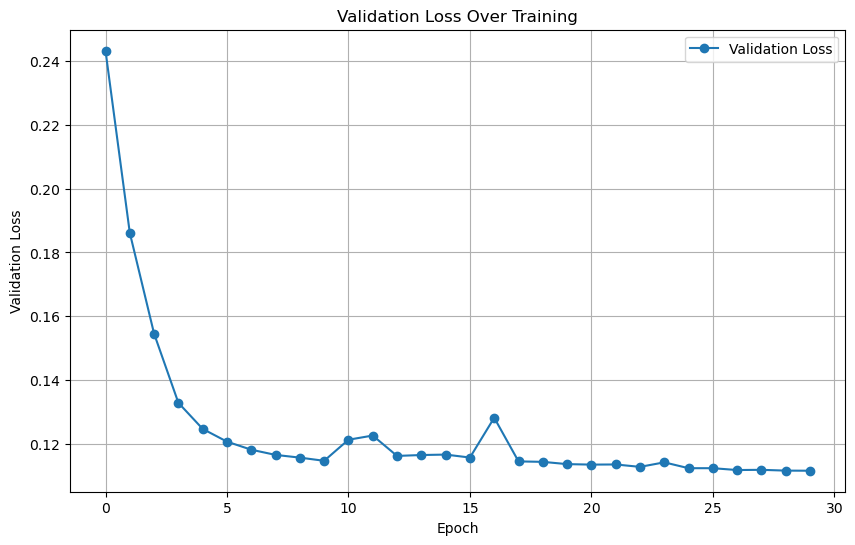

In [2]:
# Plot validation loss
plt.figure(figsize=(10, 6))
plt.plot(lightning_module.val_loss_epochs, lightning_module.validation_losses, 
         marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Training')
plt.legend()
plt.grid(True)
plt.show()

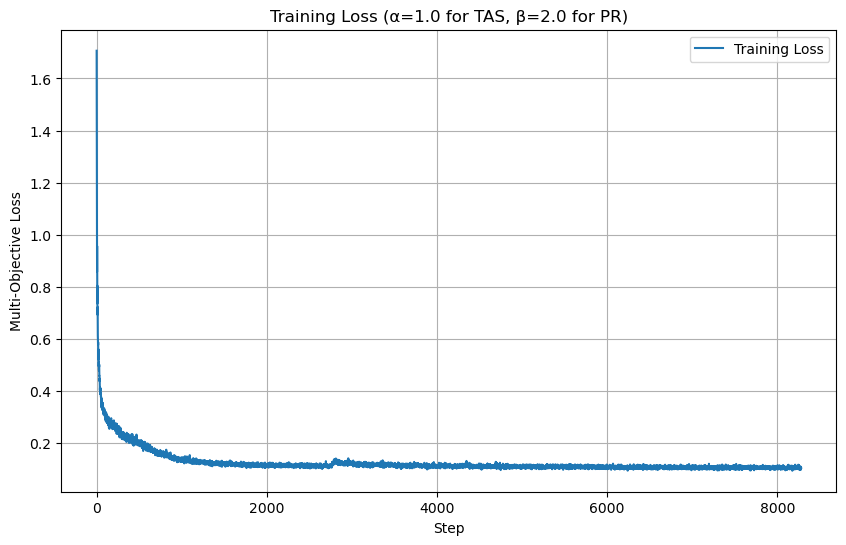

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(lightning_module.training_losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Multi-Objective Loss")
plt.title("Training Loss (α=1.0 for TAS, β=2.0 for PR)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")
errors = np.mean((val_preds - val_trues)**2, axis=(1,2,3))  # MSE per sample
worst = np.argsort(errors)[-3:]  # worst 3 samples


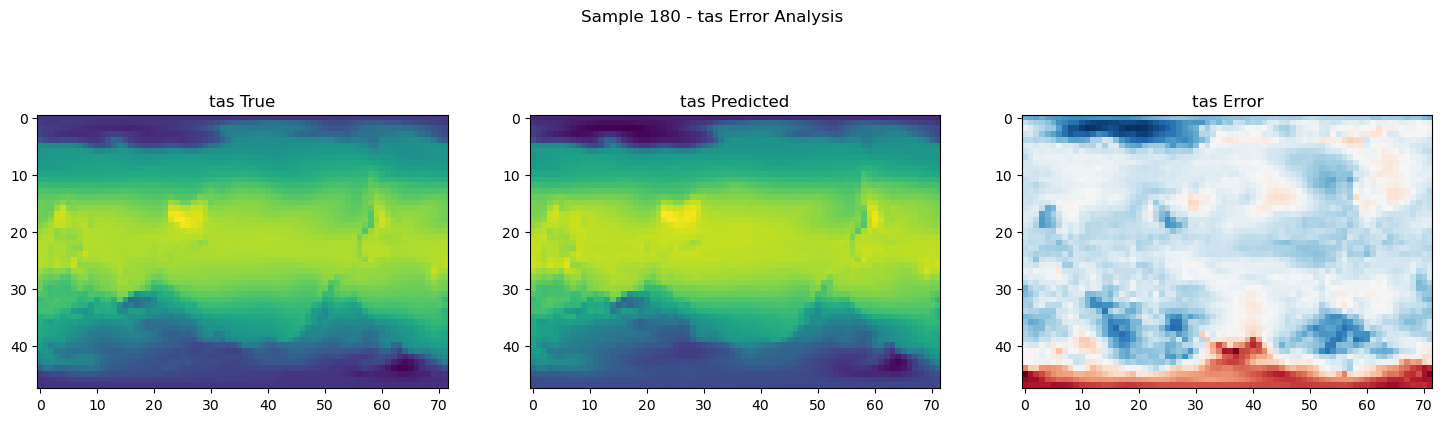

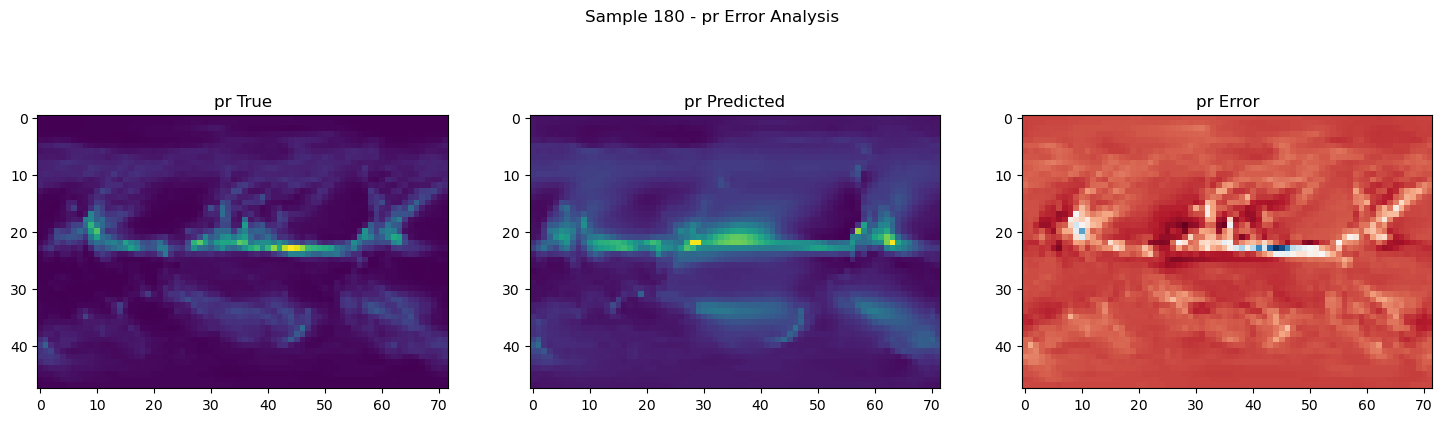

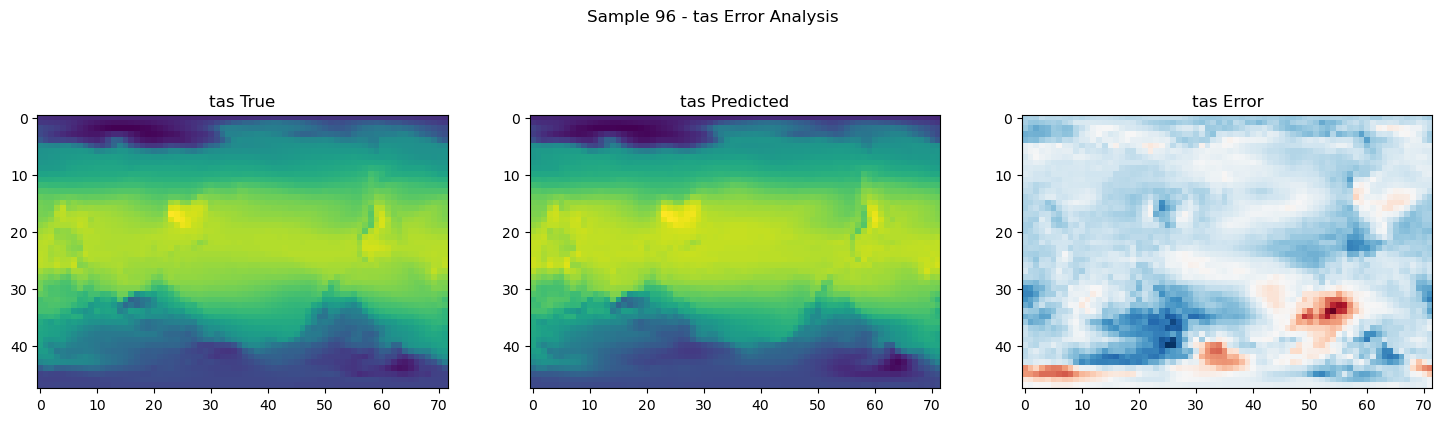

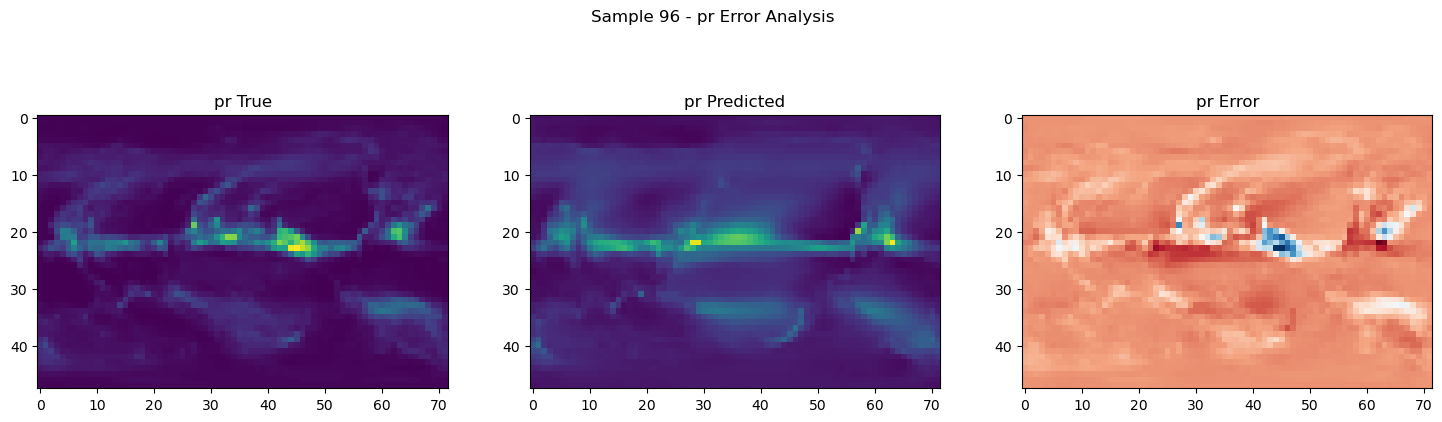

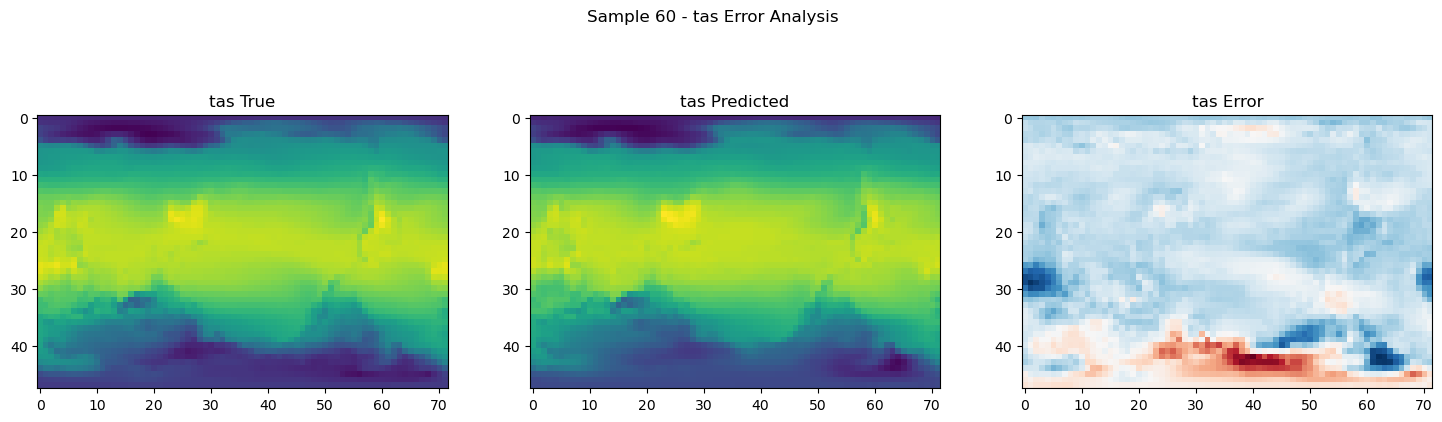

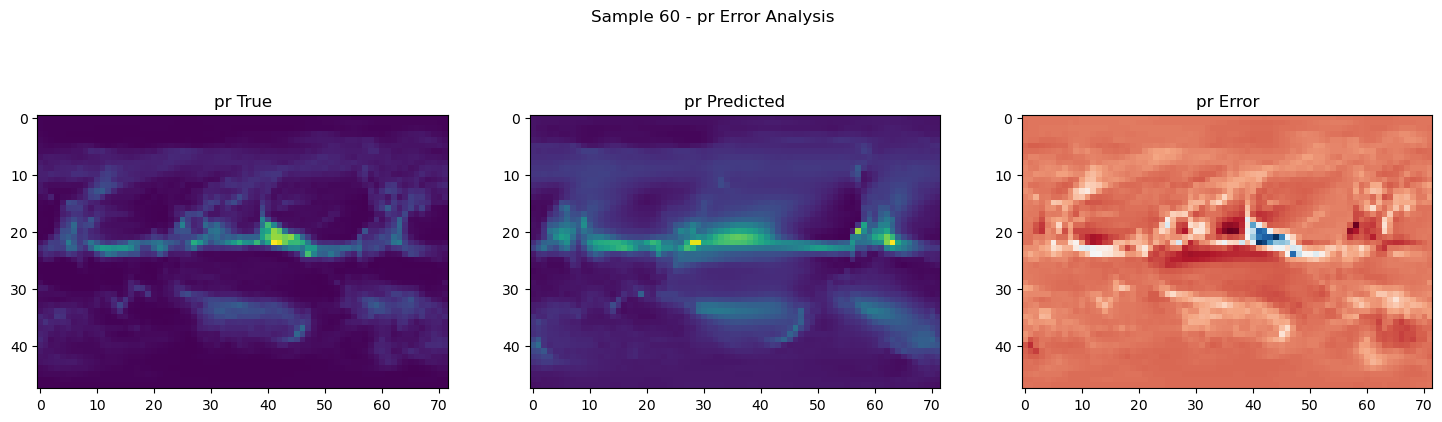

In [5]:
for idx in worst:
    for i, var in enumerate(["tas", "pr"]):
        pred = val_preds[idx, i]
        true = val_trues[idx, i]
        diff = pred - true

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        axs[0].imshow(true, cmap="viridis"); axs[0].set_title(f"{var} True")
        axs[1].imshow(pred, cmap="viridis"); axs[1].set_title(f"{var} Predicted")
        axs[2].imshow(diff, cmap="RdBu_r"); axs[2].set_title(f"{var} Error")
        plt.suptitle(f"Sample {idx} - {var} Error Analysis")
        plt.show()


In [6]:
trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 8829 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.4299, Time-Mean RMSE=290.3877, Time-Stddev MAE=3.5728
[TEST] pr: RMSE=4.2285, Time-Mean RMSE=3.8713, Time-Stddev MAE=1.1698
✅ Submission saved to: submissions/kaggle_submission_20250612_221824.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.228513240814209     │
│  test/pr/time_mean_rmse   │     3.871304512023926     │
│   test/pr/time_std_mae    │     1.169811487197876     │
│       test/tas/rmse       │     290.4299011230469     │
│  test/tas/time_mean_rmse  │      290.3876953125       │
│   test/tas/time_std_mae   │     3.572767972946167     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.4299011230469,
  'test/tas/time_mean_rmse': 290.3876953125,
  'test/tas/time_std_mae': 3.572767972946167,
  'test/pr/rmse': 4.228513240814209,
  'test/pr/time_mean_rmse': 3.871304512023926,
  'test/pr/time_std_mae': 1.169811487197876}]

In [7]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


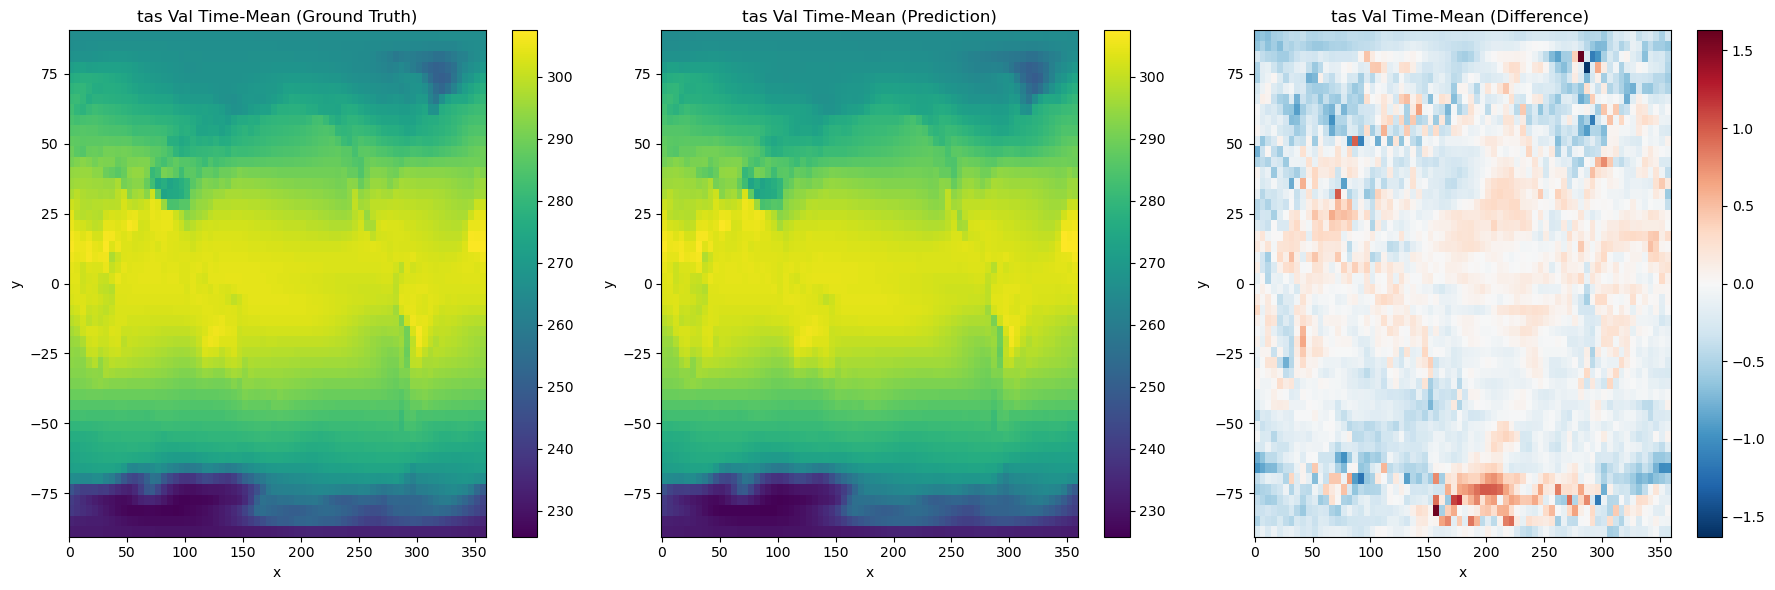

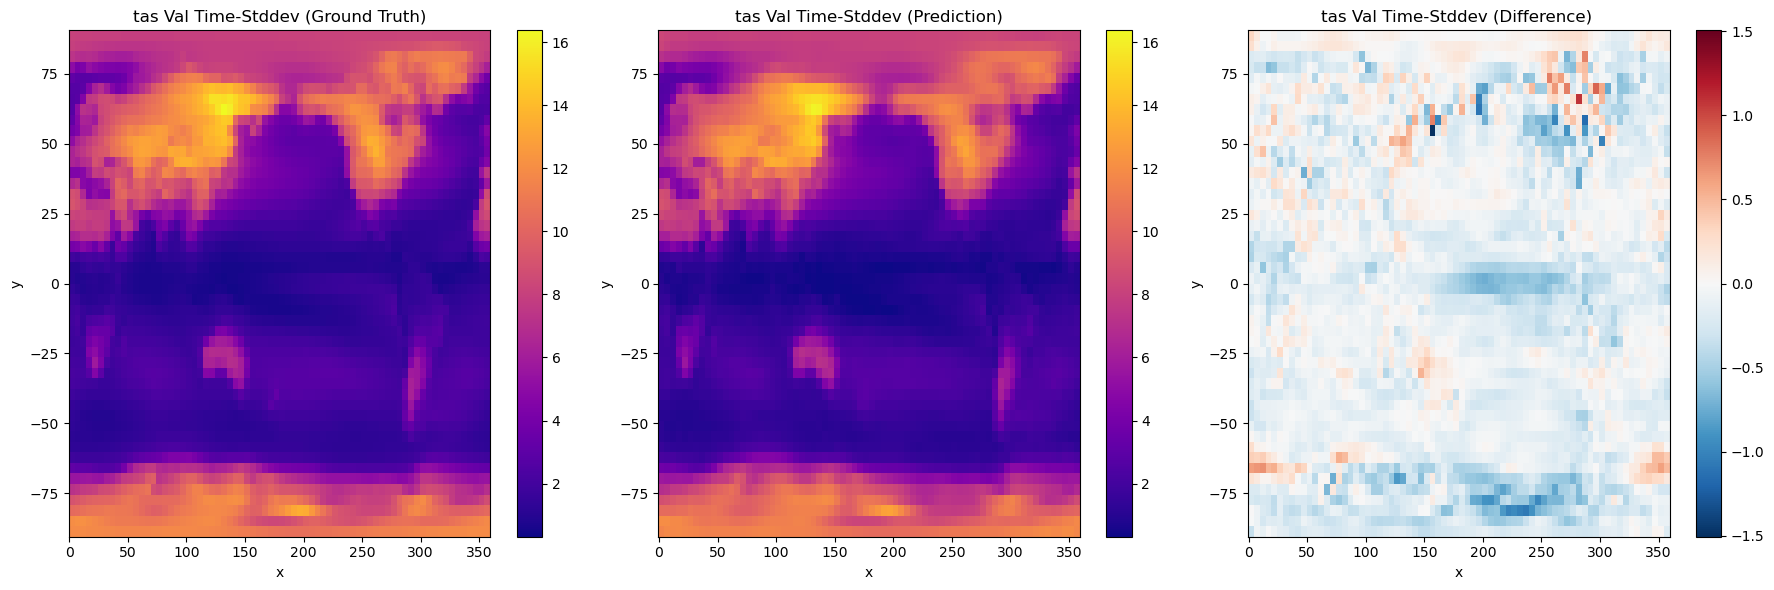

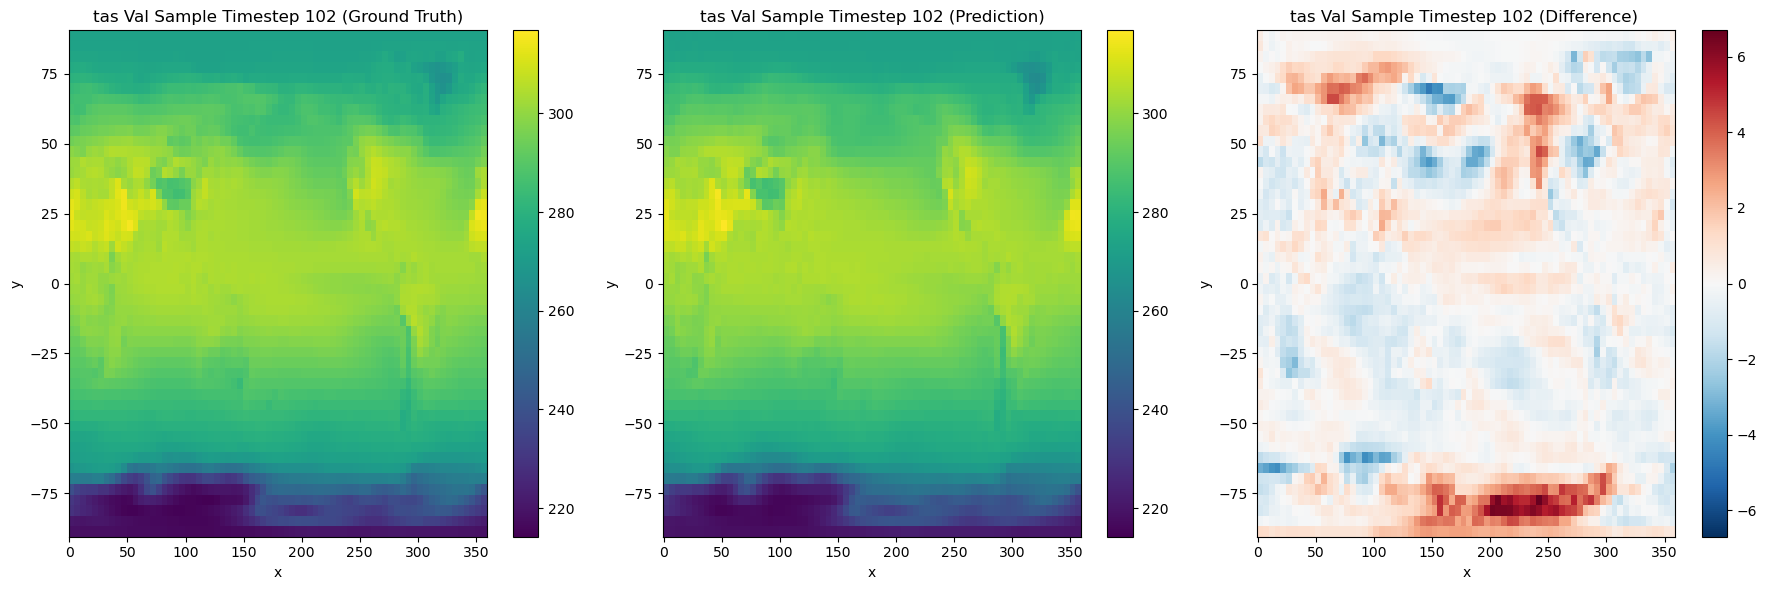

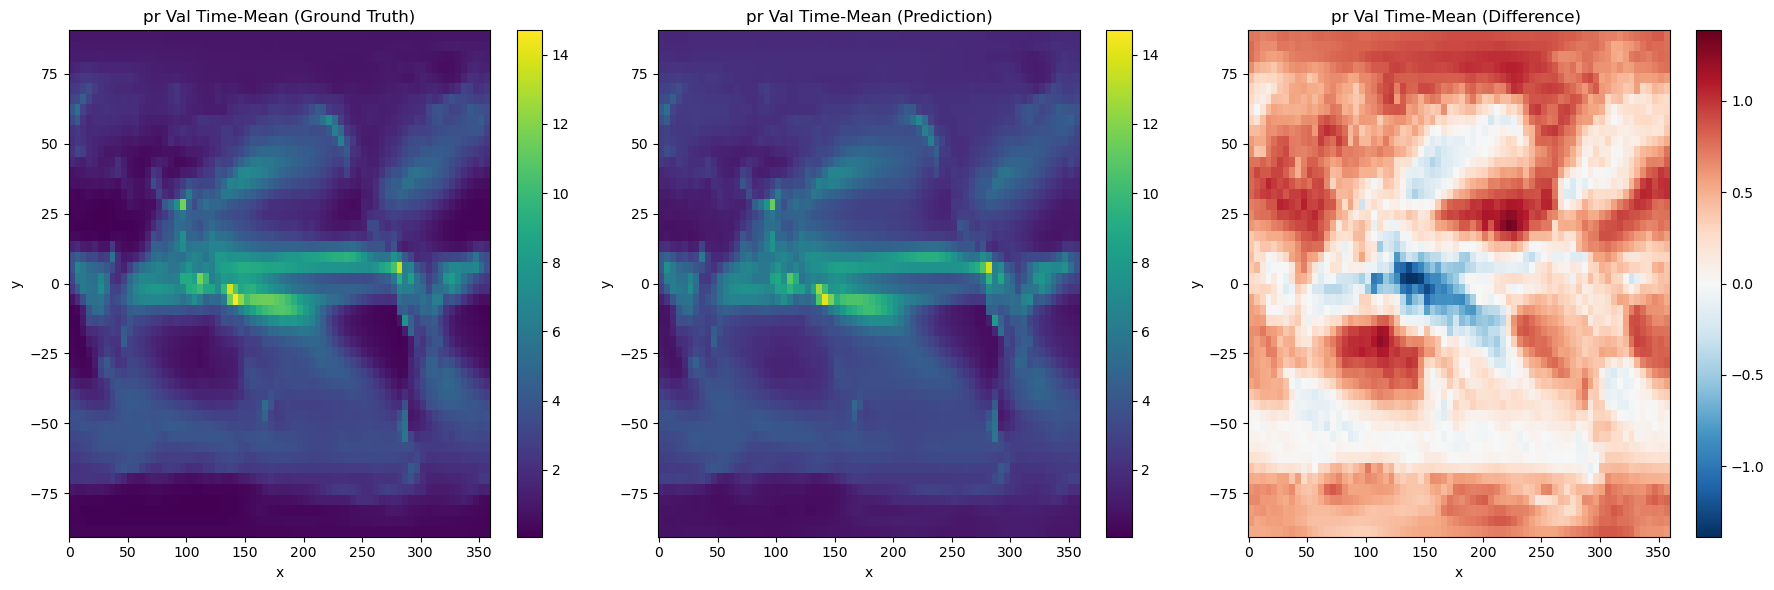

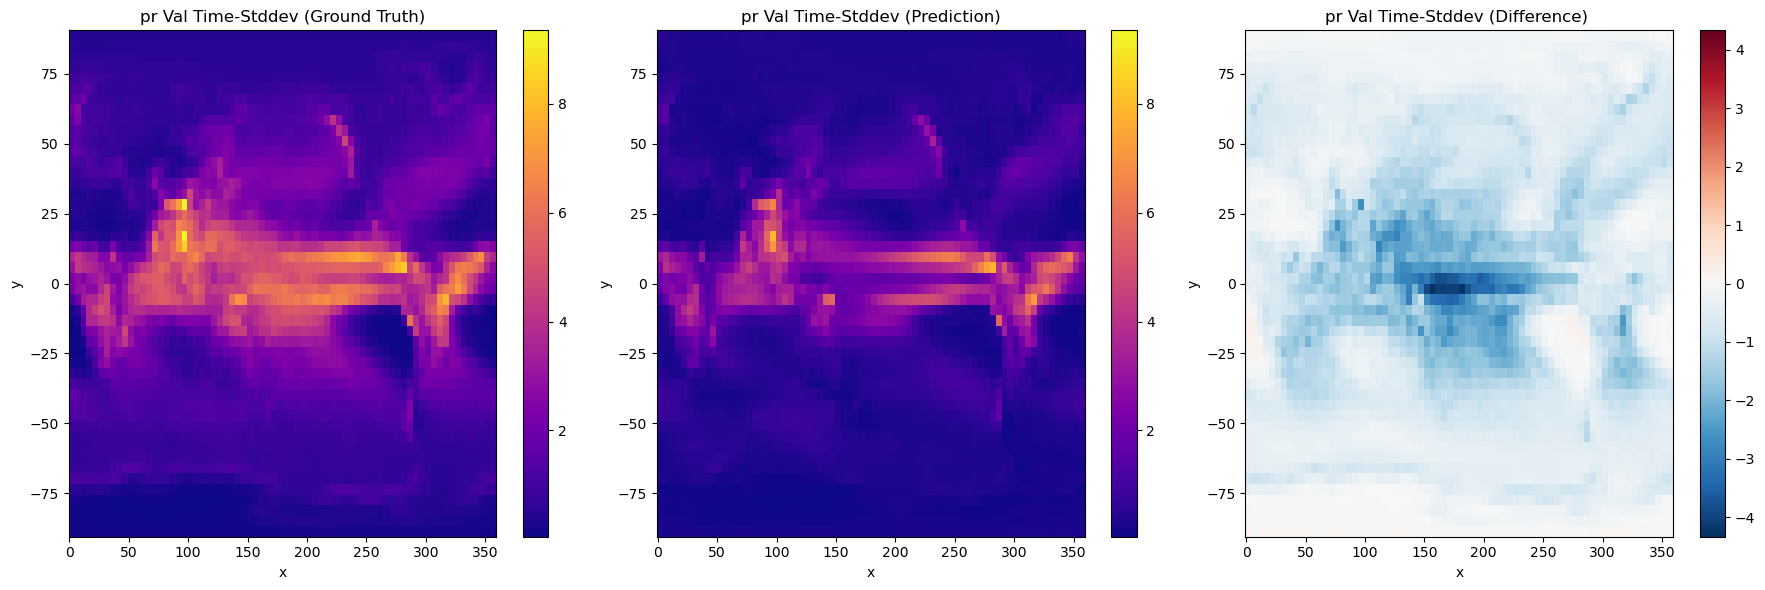

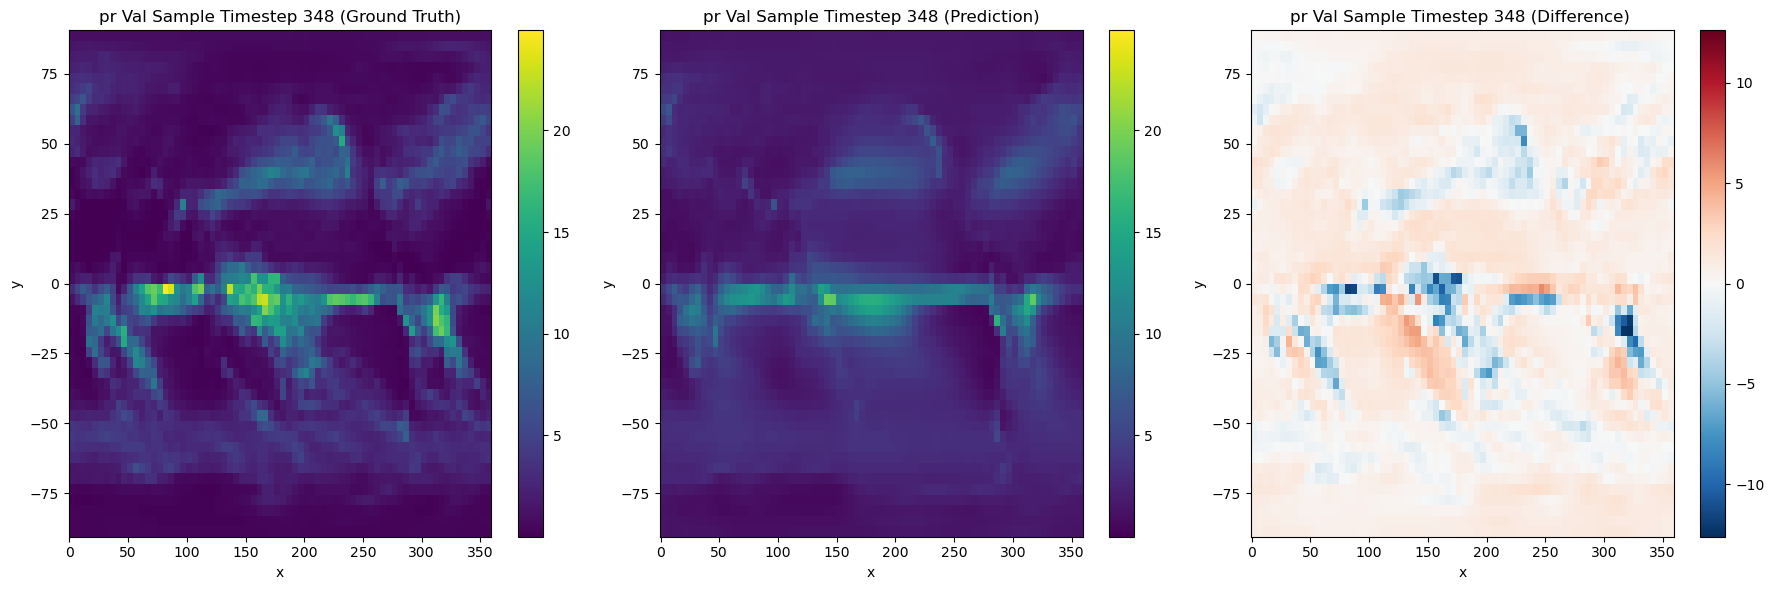

In [8]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")
